# 3. Pruning Cross-validation

Following the bias-variance trade-off we know:
* when fitting a shallow tree (underfitting) we have a high bias and a low variance
* when fitting a deep tree (overfitting) we have a low bias and a high variance

In order to find the right balance between between bias and variance we:
* fit an overly complex deep tree
* prune the tree to find the optimal subtree

Look for the smallest subtree that minimizes a penalized loss function:

$$
\begin{align}
min{f_{loss}+\alpha |T|}
\end{align}
$$

* $f_{loss}$ represents the loss function
* $\alpha$ represents the complexity parameter
* $|T|$ is the number of leaf nodes

A shallow tree results when is large and a deep tree when is small. Perform cross-validation on the complexity parameter in order to select the most suitable balance between bias and variance. 

In [92]:
# import libraries
import os
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [93]:
# generate synthetic data
x = np.linspace(start = 0, stop = 2 * np.pi, num=500)
m = 2 * np.sin(x)
y = m + np.random.normal(loc = 0, scale = 1, size = len(x))

In [94]:
# adding column name to array (and transforming it into pd.DataFrame)
x = pd.DataFrame({'feature_1':x})
y = pd.DataFrame({'y':y})

In [95]:
# fit a very deep tree
deep_tree = tree.DecisionTreeRegressor(max_depth = 20,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = 0).fit(x, y)
y_deep_tree = deep_tree.predict(x)

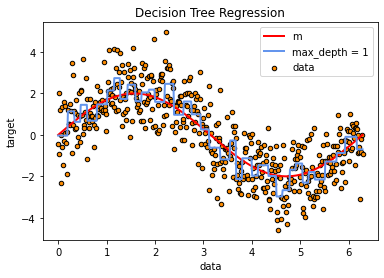

In [96]:
# Plot deep_tree
%matplotlib inline
plt.scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data") # plot raw data (including stoch. desturbance)
plt.plot(x, m, color="red", label="m", linewidth=2) # plot raw data (excluding stoch. desturbance)
plt.plot(x, y_deep_tree, color="cornflowerblue", label="max_depth = 1", linewidth=2) # depth 1
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### 3.1 Impurity of leaves vs effective alphas of pruned tree

The tree above is oviously overfitting the data. We look at the ```cost_complexity_pruning_path```, ut provides another option to control the size of a tree. We show the effect of ccp_alpha on regularizing the trees and **how to choose a ccp_alpha based on the (validation) scores**.

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides ```DecisionTreeRegressor.cost_complexity_pruning_path``` that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. 

**As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves**.

In [99]:
path = deep_tree.cost_complexity_pruning_path(x, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

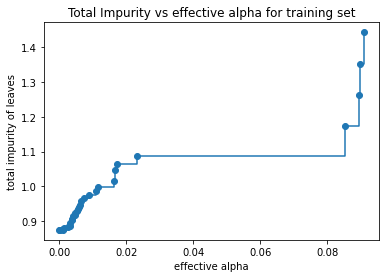

In [102]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective alphas. The last value in ```ccp_alphas``` is the alpha value that prunes the whole tree, leaving the tree, ```clfs[-1]```, with one node.

In [104]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeRegressor(max_depth = 20,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = ccp_alpha).fit(x, y)
    clfs.append(clf)

In [107]:
print(f"Number of nodes in the last tree is: {clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

Number of nodes in the last tree is: 1 with ccp_alpha: 2.033153217381094


For the remainder of this example, we remove the last element in ```clfs``` and ```ccp_alphas```, because it is the trivial tree with only one node. Here **we show that the number of nodes and tree depth decreases as alpha increases**.

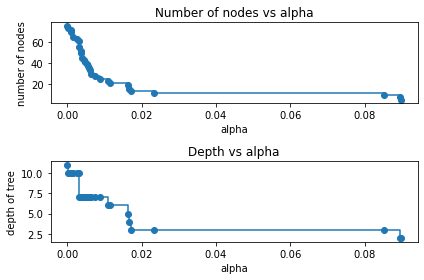

In [109]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
score = [clf.score(y, clf.predict(x)) for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### 3.2 Selecting optimal alpha via cross-validation

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    regr_dt = tree.DecisionTreeRegressor(max_depth = 30,
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = ccp_alpha).fit(x, y)
    
    predictions = regr_dt.predict(x)
    cvs = np.mean(cross_val_score(regr_dt, x, y, cv = 10, scoring='r2'))
    node_counts = regr_dt.tree_.node_count
    depth = regr_dt.tree_.max_depth
    
    alpha_loop_values.append([ccp_alpha, node_counts, depth,
                              cvs])
#best_alpha = float(alpha_results[alpha_results.cvs == alpha_results.cvs.max()].alpha)
#print(f'best alpha: {best_alpha}')

**Note:** The unified scoring API always maximizes the score, so scores which need to be minimized are negated in order for the unified scoring API to work correctly. The score that is returned is therefore negated when it is a score that should be minimized and left positive if it is a score that should be maximized.

In [134]:
alpha_results = pd.DataFrame(alpha_loop_values, 
                         columns=['alpha', 'node_counts', 'depth','cvs'])

# taking absolute value of cvs
alpha_results['cvs'] = np.abs(alpha_results.cvs)
alpha_results

,alpha,node_counts,depth,cvs
0,0.000000,75,11,0.102596
1,0.000191,73,10,0.101899
2,0.000938,71,10,0.101198
3,0.001017,69,10,0.101198
4,0.001414,65,10,0.105515
5,0.002700,63,10,0.123278
6,0.003199,61,10,0.119021
7,0.003206,55,7,0.119021
8,0.003629,51,7,0.119021
9,0.003741,49,7,0.113199


In [159]:
alpha_results = alpha_results.loc[(alpha_results['cvs']==np.max(alpha_results['cvs']))]
best_alpha = alpha_results.loc[(alpha_results['depth']==np.max(alpha_results['depth']))]

In [160]:
regr_dt = tree.DecisionTreeRegressor(max_depth = int(best_alpha.depth),
                                      min_samples_split = 10,
                                      min_samples_leaf = 10,
                                      ccp_alpha = float(best_alpha.alpha)).fit(x, y)
y_deep_tree = regr_dt.predict(x)

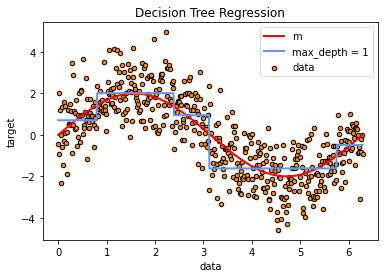

In [161]:
# Plot deep_tree
plt.figure()
plt.scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data") # plot raw data (including stoch. desturbance)
plt.plot(x, m, color="red", label="m", linewidth=2) # plot raw data (excluding stoch. desturbance)
plt.plot(x, y_deep_tree, color="cornflowerblue", label="max_depth = 1", linewidth=2) # depth 1
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [ ]:
train_scores = [clf.score(x, y) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("r2")
ax.set_title("r2 vs alpha for training set")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
#ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#        drawstyle="steps-post")
ax.legend()
plt.show()